# Introduction
After studying the [Fire Program Analysis (FPA) fire-occurrence database](https://www.fs.usda.gov/rds/archive/Product/RDS-2013-0009.4/) of wildfires from 1992 to 2015 in the United States in [Part 1](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/Part%201%20-%20Wildfire%20Prevention%20-%20Learning%20From%20the%20Past.ipynb), we have learned that California has had the greatest number of human-caused wildfires, especially Class G wildfires that have burned more than 5000 acres. One of our motivations behind exploring the database of wildfires, especially in California, was the state's recent history of devastating wildfires, including the [Mendocino Complex Fire](https://www.nytimes.com/2018/08/07/us/california-fires-mendocino.html), the [Carr Fire](https://www.washingtonpost.com/news/post-nation/wp/2018/07/29/grandma-did-everything-she-could-carr-fire-claims-3-more-victims-spreads-in-every-direction/?utm_term=.9a8208a9405a), the [October 2017 Northern California wildfires](https://www.nytimes.com/2017/10/10/us/california-fires.html), and most recently the [Woolsey Fire](https://deadline.com/2018/11/malibu-mandatory-evacuation-socal-fires-1202498934/) and the [Camp Fire](https://www.nytimes.com/2018/11/10/us/california-wildfires-paradise-malibu.html), the deadliest wildfire in California history. 

In California, we saw that the wildfires that have burned the largest number of acres occurred from the months July to October. The summer to autumn may be considered to be the fire season for the state. We wonder if the devastation of the wildfires is connected to not only the location (i.e. is the location vulnerable to large wildfires), but also the climate. Unfortunately, the FPA database did not contain information about the temperatures, so we chose to study the temperature in California by studying the [Berkeley Earth dataset](http://berkeleyearth.org/data/).

In our analysis of the monthly average temperature time series in California in [Part 2](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/Part%202%20-%20A%20Look%20into%20Changes%20in%20Temperatures%20in%20California.ipynb), we noted that there was an increase in temperatures (especially the low and average), and these values may continue to increase in the next few years. Will the increasing temperatures come together with more destructive wildfires? And can we introduce other variables, like the humidity, to make conclusions and predictions for the destructive power of fires? We wish to expand this analysis on the entirety of the United States.

# Wildfires and Temperatures - Combining Two Datasets
## Wildfire Database
The original wildfire database did not contain any information about the temperatures reported when the wildfires were discovered (and contained). We believe the temperature values may be relevant, especially if a wildfire ends up growing to uncontrollable sizes. Our intent is to combine the FPA database with the Berkeley Earth dataset.

Let's begin by revisiting the FPA database. We will use functions defined in sqlite_helpers to make SQL queries through Python.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import sqlite_helpers
import datetime
style.use('fivethirtyeight')

# Define colors for figures
color_map = [[55/255,126/255,184/255], [1,127/255,0], [77/255,175/255,74/255], [247/255,129/255,191/255],
             [166/255,86/255,40/255], [152/255,78/255,163/255], [153/255,153/255,153/255],
             [228/255,26/255,28/255], [55/255,126/255,184/255], [1,127/255,0]]

# Show figures inline, show all DataFrame columns
%matplotlib inline
pd.set_option('display.max_columns', 100)

database = 'FPA_FOD_20170508.sqlite'

sqlite_helpers.run_query(database, '''SELECT * FROM Fires LIMIT 1''')

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33,1730,0.1,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...


Let us now load the wildfires reported in the United States from 1992 to 2015 from the database into a DataFrame. We will focus on wildfires that have burned 10 or more acres, meaning we will be excluding the wildfires categorized in the size classes A and B. We will also only look at human-caused wildfires, so we will exclude fires where the causes are listed under "Lightning" (natural), "Miscellaneous" (may include fires sparked from natural causes), and "Missing/Undefined" (we'd rather know the fires are human-caused).

In [4]:
# Query the wildfires database, obtaining only the fires in California
query = '''
SELECT * FROM Fires
WHERE 
    NOT (FIRE_SIZE_CLASS = 'A' OR FIRE_SIZE_CLASS = 'B')
    AND NOT STAT_CAUSE_DESCR = 'Missing/Undefined'
'''

fires_sql = sqlite_helpers.run_query(database, query)

print('Shape of the DataFrame:')
print(fires_sql.shape)

fires_sql.head()


Shape of the DataFrame:
(247096, 39)


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,17,17,FS-1418878,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,109,23,,POWER,CA-ENF-017646,POWER,CA3850212028020041006,POWER,None,2004,2453284.5,280,1415,2.0,Equipment Use,2453299.5,295.0,1000,16823.0,G,38.523333,-120.211667,5.0,USFS,CA,5,005,Amador,b'\x00\x01\xad\x10\x00\x00dS\\\xf2\x8b\r^\xc0\...
1,18,18,FS-1418881,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,111,35,BHA3,FREDS,CA-ENF-18044,FREDS,CA3878712031820041013,FREDS,None,2004,2453291.5,287,1618,2.0,Equipment Use,2453295.5,291.0,1800,7700.0,G,38.780000,-120.260000,5.0,USFS,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00p=\n\xd7\xa3\x10^\xc...
2,26,26,FS-1418897,FED,FS-FIRESTAT,FS,USNMLNF,Lincoln National Forest,0308,Lincoln National Forest,22,NM-LNF-022,AVP4,BACHELOR,None,None,None,None,None,2004,2453206.5,202,1405,1.0,Lightning,2453206.5,202.0,1600,10.0,C,33.315833,-105.512222,5.0,USFS,NM,27,027,Lincoln,b'\x00\x01\xad\x10\x00\x00\xcc\xcb\xb4?\xc8`Z\...
3,38,38,FS-1418918,FED,FS-FIRESTAT,FS,USNCNCF,National Forests in North Carolina,0811,National Forests in North Carolina,2,002,BJ66,HOWARD GAP,None,None,None,None,None,2005,2453397.5,27,2200,7.0,Arson,2453398.5,28.0,0300,50.3,C,35.000278,-83.351111,5.0,USFS,NC,113,113,Macon,b'\x00\x01\xad\x10\x00\x00\x94\xad\xbb\x9ax\xd...
4,40,40,FS-1418920,FED,FS-FIRESTAT,FS,USNCNCF,National Forests in North Carolina,0811,National Forests in North Carolina,4,2,BKC8,AUSTIN CREEK,NC-NCS-050201401,Austin Creek,None,None,None,2005,2453413.5,43,1520,5.0,Debris Burning,2453414.5,44.0,0330,125.0,D,36.001667,-81.590000,14.0,MISSING/NOT SPECIFIED,NC,27,027,Caldwell,b'\x00\x01\xad\x10\x00\x00\xf4(\\\x8f\xc2eT\xc...


This DataFrame of human-caused wildfires currently has 39 features. Our objective is to make predictions about wildfire sizes to get a sense for which areas in the United States are vulnerable. We can trim this number down by removing redundant or unnecessary features. The features we will remove include:

- Identification columns (like OBJECTID, FOD_ID, FIRE_NAME, or COMPLEX_NAME)
- Columns related to fire reporting
- DIRECTORY_DOY and CONT_DOY: Redundant information provided from DISCOVERY_DATE and CONT_DATE
- STAT_CAUSE_CODE and OWNER_CODE: Redundant information provided from STAT_CAUSE_DESCR and OWNER_DESCR
- COUNTY and FIPS_CODE: Redundant information provided from FIPS_NAME

We may continue removing some of the remaining columns, but for now, we will reduce the number of columns from 39 to 13. We note that we are keeping the STATE column for future use.

In [5]:
columns = ['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_TIME', 'STAT_CAUSE_DESCR',
           'CONT_DATE', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
           'OWNER_DESCR', 'STATE', 'FIPS_NAME']

fires = fires_sql[columns]

print(fires.shape)

fires.head()

(247096, 13)


,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME
0,2004,2453284.5,1415,Equipment Use,2453299.5,1000,16823.0,G,38.523333,-120.211667,USFS,CA,Amador
1,2004,2453291.5,1618,Equipment Use,2453295.5,1800,7700.0,G,38.780000,-120.260000,USFS,CA,El Dorado
2,2004,2453206.5,1405,Lightning,2453206.5,1600,10.0,C,33.315833,-105.512222,USFS,NM,Lincoln
3,2005,2453397.5,2200,Arson,2453398.5,0300,50.3,C,35.000278,-83.351111,USFS,NC,Macon
4,2005,2453413.5,1520,Debris Burning,2453414.5,0330,125.0,D,36.001667,-81.590000,MISSING/NOT SPECIFIED,NC,Caldwell


As we have done in Part 1, let's convert the DISCOVERY_DATE and CONT_DATE columns into datetime columns. We will also convert the DISCOVERY_TIME and CONT_TIME columns into datetime columns.

In [6]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()    # Reference for Julian time
fires.loc[:, 'DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'] - epoch, unit='D', errors = 'coerce')
fires.loc[:, 'CONT_DATE'] = pd.to_datetime(fires['CONT_DATE'] - epoch, unit = 'D', errors = 'coerce')

fires.loc[:, 'DISCOVERY_TIME'] = pd.to_datetime(fires['DISCOVERY_TIME'], format = "%H%M", errors = 'coerce').dt.time
fires.loc[:, 'CONT_TIME'] = pd.to_datetime(fires['CONT_TIME'], format = "%H%M", errors = 'coerce').dt.time

fires.head(10)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME
0,2004,2004-10-06,14:15:00,Equipment Use,2004-10-21,10:00:00,16823.0,G,38.523333,-120.211667,USFS,CA,Amador
1,2004,2004-10-13,16:18:00,Equipment Use,2004-10-17,18:00:00,7700.0,G,38.780000,-120.260000,USFS,CA,El Dorado
2,2004,2004-07-20,14:05:00,Lightning,2004-07-20,16:00:00,10.0,C,33.315833,-105.512222,USFS,NM,Lincoln
3,2005,2005-01-27,22:00:00,Arson,2005-01-28,03:00:00,50.3,C,35.000278,-83.351111,USFS,NC,Macon
4,2005,2005-02-12,15:20:00,Debris Burning,2005-02-13,03:30:00,125.0,D,36.001667,-81.590000,MISSING/NOT SPECIFIED,NC,Caldwell
5,2005,2005-04-16,16:25:00,Debris Burning,2005-04-16,22:00:00,25.0,C,35.985000,-81.851667,MISSING/NOT SPECIFIED,NC,Avery
6,2005,2005-05-09,19:00:00,Debris Burning,2005-05-09,23:30:00,10.0,C,36.035000,-81.585000,MISSING/NOT SPECIFIED,NC,Caldwell
7,2005,2005-03-11,13:30:00,Miscellaneous,2005-03-11,19:30:00,10.0,C,35.001389,-83.384167,MISSING/NOT SPECIFIED,NC,Macon
8,2005,2005-05-02,20:00:00,Debris Burning,2005-05-02,22:00:00,17.0,C,48.966667,-115.206667,STATE OR PRIVATE,MT,Lincoln
9,2005,2005-07-07,17:31:00,Lightning,2005-07-08,11:00:00,45.6,C,32.467222,-104.941667,USFS,NM,Chaves


We will keep the date and time columns for now, even though we do not expect these columns to have direct relationships with the wildfire sizes (which will be our target column). As we have previously stated, we are interested in introducing the reported average temperature when the fires were discovered, as the climate may have a significant effect.

## Temperature Dataset

We previously looked at a monthly time series of aggregate temperature values for the entire state of California. However, California is a large state with a variety in ecosystems and climates. Northern California is different from southern California, much like how coastal California is different from inland California, much like how the deserts in California are different from the Sierra Nevadas. By extension, looking at monthly time series of individual states only provides us with aggregate values.

We are instead going to look at gridded daily temperature data from Berkeley Earth. We have obtained files that report temperatures on a $1^\mathrm{o}$ x $1^\mathrm{o}$ latitude-longitude grid for every day from the start of 1990 to mid 2018. This will be convenient for our analysis as the wildfires are reported on specific days from 1992 to 2015, and their locations are reported in terms of latitude and longitude coordinates (Berkeley Earth primarily reported temperatures on equal-area grid cells different from the latitude-longitude grid).

The files that report the temperature grids are three NC files, one for each decade. NC files can be read through Python with the [netCDF4](http://unidata.github.io/netcdf4-python/) module, which requires the [netCDF-4 C library](https://github.com/Unidata/netcdf-c/releases) installed on your computer, as the Python module interfaces with this C library. A majority of the work of reading the NC files and converting the temperature grids into a single Python dictionary is performed in [temperature_us_grid.py](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/temperature_us_grid.py). For this project, we are looking at a subgrid of coordinates that contain most of the United States.

This program ultimately saves the dictionary in a pickle file, which we will now read in this project. The pickle file, "temperature_grid.pickle", can be downloaded [here](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/temperature_grid.pickle.zip).

In [7]:
import pickle

with open('temperature_us_grid.pickle', 'rb') as handle:
    temp_grid = pickle.load(handle)

We will define a function that will read the coordinates and discovery date of each wildfire, and output the average temperature at that location on that date. The coordinates will be rounded to the nearest 0.5 (but not 0.0), as that is how the latitudes and longitudes were recorded in the Berkeley Earth dataset.

In [8]:
# Define a function that returns a temperature from the temperature dictionary, given the coordinates and date
def add_temperature(row):
    # Key of the dictionary is (year, month, day)
    key_date = (row['DISCOVERY_DATE'].year, row['DISCOVERY_DATE'].month, row['DISCOVERY_DATE'].day)
    
    # Latitude and longitudes from the Berkeley Earth dataset are in 1 degree x 1 degree squares, values at 0.5
    latitude = np.floor(row['LATITUDE']) + .5
    longitude = np.floor(row['LONGITUDE']) + .5
    
    # Obtain the temperature
    temperature = temp_grid[key_date][(latitude, longitude)]
    
    return temperature

It is now time to combine the two datasets by adding a temperature column to the fires DataFrame.

In [9]:
fires['TEMPERATURE'] = fires.apply(add_temperature, axis = 1)
fires.head(15)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,TEMPERATURE
0,2004,2004-10-06,14:15:00,Equipment Use,2004-10-21,10:00:00,16823.0,G,38.523333,-120.211667,USFS,CA,Amador,17.886902
1,2004,2004-10-13,16:18:00,Equipment Use,2004-10-17,18:00:00,7700.0,G,38.780000,-120.260000,USFS,CA,El Dorado,19.159416
2,2004,2004-07-20,14:05:00,Lightning,2004-07-20,16:00:00,10.0,C,33.315833,-105.512222,USFS,NM,Lincoln,25.693935
3,2005,2005-01-27,22:00:00,Arson,2005-01-28,03:00:00,50.3,C,35.000278,-83.351111,USFS,NC,Macon,5.026590
4,2005,2005-02-12,15:20:00,Debris Burning,2005-02-13,03:30:00,125.0,D,36.001667,-81.590000,MISSING/NOT SPECIFIED,NC,Caldwell,0.772786
5,2005,2005-04-16,16:25:00,Debris Burning,2005-04-16,22:00:00,25.0,C,35.985000,-81.851667,MISSING/NOT SPECIFIED,NC,Avery,10.880407
6,2005,2005-05-09,19:00:00,Debris Burning,2005-05-09,23:30:00,10.0,C,36.035000,-81.585000,MISSING/NOT SPECIFIED,NC,Caldwell,15.508547
7,2005,2005-03-11,13:30:00,Miscellaneous,2005-03-11,19:30:00,10.0,C,35.001389,-83.384167,MISSING/NOT SPECIFIED,NC,Macon,4.157602
8,2005,2005-05-02,20:00:00,Debris Burning,2005-05-02,22:00:00,17.0,C,48.966667,-115.206667,STATE OR PRIVATE,MT,Lincoln,7.607604
9,2005,2005-07-07,17:31:00,Lightning,2005-07-08,11:00:00,45.6,C,32.467222,-104.941667,USFS,NM,Chaves,28.316917


We should specify to the reader that the temperatures reported in the Berkeley Earth dataset are in degrees Celsius. If the reader is adamant about using Fahrenheit, they can perform the following conversion:

$T_{Fahrenheit} = (T_{Celsius} \times 9/5) + 32$

# Further Feature Preparation
Let us say we wish to use machine learning algorithms to make predictions. After all, we have now added the temperature variable to our dataset. Without addressing whether or not we can even make predictions with trained machine learning models with our current dataset, we would want to further select or engineer the features. We also need to address missing values. Let us look at missing values first.

In [10]:
fires.isnull().sum().sort_values(ascending = False)

CONT_TIME           129280
CONT_DATE           121457
DISCOVERY_TIME      113952
FIPS_NAME            88402
TEMPERATURE             79
STATE                    0
OWNER_DESCR              0
LONGITUDE                0
LATITUDE                 0
FIRE_SIZE_CLASS          0
FIRE_SIZE                0
STAT_CAUSE_DESCR         0
DISCOVERY_DATE           0
FIRE_YEAR                0
dtype: int64

We had hoped to combine the date and time columns to introduce a new variable that reports the length of time from when a fire was discovered to when it was contained. However, the CONT_TIME, CONT_DATE, and DISCOVERY_TIME columns contain many missing values. If we were to drop the data points with missing values for CONT_TIME, CONT_DATE, and DISCOVERY_TIME, we'd be dropping over 80,000 to over 100,000, or roughly up to 50% to half of the dataset. It will be best, instead, to remove these columns, considering the difficulty of imputation. 

We notice that there are a few missing values in the TEMPERATURE column. Let us investigate this, considering we went through the trouble of adding this new column.

In [12]:
fires[fires['TEMPERATURE'].isnull()].head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,TEMPERATURE
43081,2006,2006-11-09,13:28:00,Equipment Use,2006-11-09,17:30:00,13.0,C,33.993300,-119.695100,NPS,CA,None,NaN
43669,1992,1992-03-28,16:30:00,Arson,1992-03-28,NaT,17.2,C,24.700000,-81.366667,FWS,FL,None,NaN
43670,1992,1992-08-15,16:00:00,Miscellaneous,NaT,NaT,35.0,C,24.700000,-81.350000,FWS,FL,None,NaN
44122,1994,1994-02-06,19:00:00,Smoking,1994-02-06,NaT,20.0,C,17.983333,-67.183333,FWS,PR,None,NaN
44703,1997,1997-05-06,14:45:00,Debris Burning,NaT,NaT,75.0,C,17.965500,-67.183333,FWS,PR,None,NaN


We are only looking at five of the 39 fires where the reported temperature values are missing. These fires were discovered in places including:
- Ventura, CA
- Big Pine Key, FL
- Cabo Rojo, Puerto Rico

What these locations have in common is that they are close to the sea. 

What happened is that the coordinates above were estimated to be on the Pacific or Atlantic Oceans in the Berkeley Earth daily gridded dataset. Our daily temperature data only reported temperatures on land. 

Berkeley Earth has an additional dataset with gridded temperature measurements on both land and oceans, but these datasets are monthly. We can still pull temperatures from this dataset, but the wildfires above will be paired together with average monthly temperatures.

We have compiled the monthly gridded dataset into a [pickle file](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/us_month_land_and_sea.pickle.zip), much like what we have done with the daily gridded data.

In [13]:
with open('us_month_land_and_sea.pickle', 'rb') as handle:
    land_sea = pickle.load(handle)
    
# Define a function that returns a temperature from the temperature dictionary, given the coordinates and date
def add_sea_temperature(row):
    # Key of the dictionary is (year, month, day)
    key_date = (row['DISCOVERY_DATE'].year, row['DISCOVERY_DATE'].month)
    
    # Latitude and longitudes from the Berkeley Earth dataset are in 1 degree x 1 degree squares, values at 0.5
    latitude = np.floor(row['LATITUDE']) + .5
    longitude = np.floor(row['LONGITUDE']) + .5
    
    # Obtain the temperature
    temperature = land_sea[key_date][(latitude, longitude)]
    
    return temperature

In [14]:
fires.loc[fires['TEMPERATURE'].isnull(),'TEMPERATURE'] = \
fires.loc[fires['TEMPERATURE'].isnull()].apply(add_sea_temperature, axis = 1)

fires.isnull().sum().sort_values(ascending = False)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CONT_TIME           129280
CONT_DATE           121457
DISCOVERY_TIME      113952
FIPS_NAME            88402
TEMPERATURE              0
STATE                    0
OWNER_DESCR              0
LONGITUDE                0
LATITUDE                 0
FIRE_SIZE_CLASS          0
FIRE_SIZE                0
STAT_CAUSE_DESCR         0
DISCOVERY_DATE           0
FIRE_YEAR                0
dtype: int64

We no longer have missing values for the temperature column.

We would likely not use FIPS_NAME for machine learning. The purpose of the column was to tell us the counties in which the fires have occurred, but we can also infer this information from the LATITUDE and LONGITUDE columns.

We have two other categorical columns: STAT_CAUSE_DESCR (cause of fire) and OWNER_DESCR (owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident). Let us examine the OWNER_DESCR column.

In [15]:
fires['OWNER_DESCR'].unique()

array(['USFS', 'MISSING/NOT SPECIFIED', 'STATE OR PRIVATE',
       'OTHER FEDERAL', 'BIA', 'FWS', 'TRIBAL', 'PRIVATE', 'STATE', 'NPS',
       'BLM', 'BOR', 'FOREIGN', 'COUNTY', 'MUNICIPAL/LOCAL',
       'UNDEFINED FEDERAL'], dtype=object)

Initially, we kept this column in case this provided information about the land that got burned by wildfires. But this information just tells us ownership, information that may not be related to fire sizes. If we had wanted to make dummy columns from this categorical features, we would have ended up with 15 additional dummy columns, which would have significantly increased the number of features in our dataset.

What should we keep, then? We're keeping "LATITUDE" and "LONGITUDE", as we wish to see what locations are vulnerable to large wildfires. We are also keeping the "TEMPERATURE" column, as the climate may have an effect on the wildfires sizes. As we have stated beforehand, we are keeping "STAT_CAUSE_DESCR". We are still keeping "STATE" for future use.

We are removing the following columns:
- OWNER_DESCR
- Date and time columns with too many missing values
- DISCOVERY_DATE: This column is effectively replaced by the TEMPERATURE column, which contains numerical values that are more likely to have a relationship with the target variable, FIRE_SIZE. The date by itself may not be a useful variable for predicting wildfire sizes. However, for future feature engineering, we will keep this column until we need to do machine learning.
- FIRE_SIZE_CLASS: Redundant. Determined by FIRE_SIZE, our target.
- FIRE_YEAR: Same reason for DISCOVERY_DATE

In [16]:
columns = ['LATITUDE', 'LONGITUDE', 'TEMPERATURE', 'STAT_CAUSE_DESCR', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE']
fires_cleaned = fires[columns]

fires_cleaned.head()

,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE
0,38.523333,-120.211667,17.886902,Equipment Use,CA,2004-10-06,16823.0
1,38.780000,-120.260000,19.159416,Equipment Use,CA,2004-10-13,7700.0
2,33.315833,-105.512222,25.693935,Lightning,NM,2004-07-20,10.0
3,35.000278,-83.351111,5.026590,Arson,NC,2005-01-27,50.3
4,36.001667,-81.590000,0.772786,Debris Burning,NC,2005-02-12,125.0


We will do further feature engineering with the STAT_CAUSE_DESCR column. We looked at two types of wildfires in Part 1: Those with natural causes, and those caused by humans. Those with natural causes were caused by lightning and causes described by "Miscellaneous" (which can include volcanic eruptions). We wish to convert the STAT_CAUSE_DESCR categorical variable into a binary column that denotes whether or not the wildfire was caused by natural causes or not.

In [17]:
# Define function that gives 1 if a fire was caused by nature, 0 if a fire was caused by humans
def isNatural(row):
    if row['STAT_CAUSE_DESCR'] == 'Lightning' or row['STAT_CAUSE_DESCR'] == 'Miscellaneous':
        return 1
    else:
        return 0
    
fires_cleaned['NATURAL'] = fires_cleaned.apply(isNatural, axis = 1)
fires_cleaned.head(15)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL
0,38.523333,-120.211667,17.886902,Equipment Use,CA,2004-10-06,16823.0,0
1,38.780000,-120.260000,19.159416,Equipment Use,CA,2004-10-13,7700.0,0
2,33.315833,-105.512222,25.693935,Lightning,NM,2004-07-20,10.0,1
3,35.000278,-83.351111,5.026590,Arson,NC,2005-01-27,50.3,0
4,36.001667,-81.590000,0.772786,Debris Burning,NC,2005-02-12,125.0,0
5,35.985000,-81.851667,10.880407,Debris Burning,NC,2005-04-16,25.0,0
6,36.035000,-81.585000,15.508547,Debris Burning,NC,2005-05-09,10.0,0
7,35.001389,-83.384167,4.157602,Miscellaneous,NC,2005-03-11,10.0,1
8,48.966667,-115.206667,7.607604,Debris Burning,MT,2005-05-02,17.0,0
9,32.467222,-104.941667,28.316917,Lightning,NM,2005-07-07,45.6,1


We went through so much trouble to combine our wildfire database with temperatures obtained from a gridded daily dataset, a plethora of data. We did so because we believe there may be some relationship between the temperature and wildfire size. Our hypothesis, based on logic, would be that wildfires burn more acres at higher temperatures than at lower temperatures. Let us plot these variables to see.

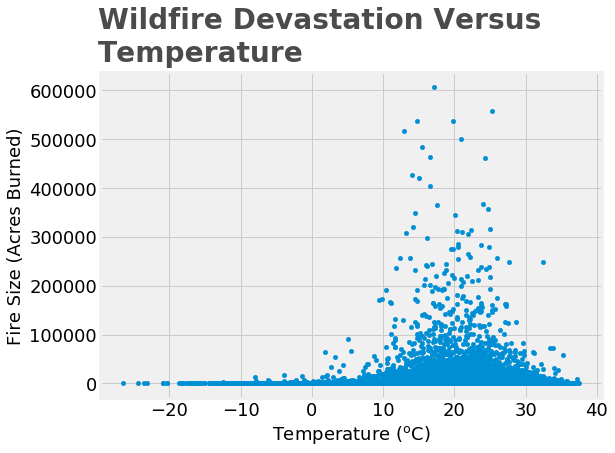

In [20]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

fires_cleaned.plot.scatter(x = 'TEMPERATURE', y = 'FIRE_SIZE', ax = ax, fontsize = 18)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 18)
ax.set_ylabel('Fire Size (Acres Burned)', fontsize = 18)

ax.text(-30, 660000, 'Wildfire Devastation Versus \nTemperature', fontsize = 28, alpha = .7, weight = 'bold');

We observe that at low temperatures, we observe small fire sizes. In fact, let us get statistics for fires below the freezing point.

In [21]:
fires_cleaned[fires_cleaned['TEMPERATURE'] < 0]['FIRE_SIZE'].describe()

count     3323.000000
mean       107.448390
std        567.387395
min         10.000000
25%         15.000000
50%         25.000000
75%         55.000000
max      16566.000000
Name: FIRE_SIZE, dtype: float64

In [22]:
fires_cleaned[fires_cleaned['TEMPERATURE'] < 0].sort_values(by = 'FIRE_SIZE', ascending = False).head()

,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL
213292,58.980000,-158.550000,-3.877760,Miscellaneous,AK,2012-11-02,16566.0,1
60915,48.995736,-96.203005,-1.382810,Debris Burning,MN,2003-03-29,15000.0,0
35544,62.965900,-162.852400,-7.916490,Equipment Use,AK,2000-12-28,12891.0,0
32656,47.957700,-95.387200,-1.136497,Miscellaneous,MN,2002-04-06,7455.0,1
99976,43.860490,-98.505680,-2.214543,Equipment Use,SD,2002-02-02,7000.0,0


The largest fire observed below freezing point burned 16566 acres in Alaska. The next four largest fires below the freezing point were caused by burning debris, equipment use, and miscellaneous. These fires took place in Minnesota, Alaska, and South Dakota.

Some of the most devastating wildfires in this dataset occurred when the temperature ranged from roughly 12 to 25$^\mathrm{o}$C. 

In [23]:
fires_cleaned.sort_values(by = 'FIRE_SIZE', ascending = False).head()

,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL
21625,61.982700,-157.085700,17.190304,Lightning,AK,1997-06-25,606945.0,1
214689,42.391894,-117.893687,25.339746,Lightning,OR,2012-07-08,558198.3,1
195087,33.606111,-109.449722,19.759136,Campfire,AZ,2011-05-29,538049.0,0
35709,65.266300,-146.885800,14.809540,Lightning,AK,2004-06-13,537627.0,1
169102,64.746700,-149.504700,12.932002,Lightning,AK,2009-06-21,517078.0,1


The largest wildfire in our original FPA database occurred in Alaska and was caused by lightning. The temperature when this fire was discovered was close to 17$^\mathrm{o}$C, or 62.6$^\mathrm{o}$F. The largest human-caused wildfire in our dataset occurred in Arizona and was caused by a campfire. The temperature when this fire was discovered was close to 20$^\mathrm{o}$C, or 68$^\mathrm{o}$F. These are not necessarily the largest temperatures in our DataFrame.

In [24]:
fires_cleaned.sort_values(by = 'TEMPERATURE', ascending = False).head()

,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL
99264,32.8480,-113.767306,37.458710,Lightning,AZ,1994-06-29,30.0,1
22808,34.7333,-115.067500,37.196999,Lightning,CA,1994-06-28,620.0,1
22809,34.5333,-115.200800,37.196999,Lightning,CA,1994-06-28,9497.0,1
22810,34.5333,-115.200800,37.196999,Lightning,CA,1994-06-28,30.0,1
36468,32.7650,-112.819900,36.795055,Miscellaneous,AZ,2005-07-17,10.0,1


What we can say so far is that we do not have a linear relationship between the wildfire size and the temperature, considering the apparent decrease in the fire size beyond 30$^\mathrm{o}$C. Let us check to see how these two variables are correlated.

In [25]:
# Calculate the Pearson correlation coefficients between the variables in our DataFrame
fire_corr = fires_cleaned.corr()
# Get the correlation coefficient for temperature and fire size
fire_corr.loc['TEMPERATURE', 'FIRE_SIZE']

0.029369297417697338

The relationship between the temperature and fire size may be too complex for a Pearson coefficient to capture.

Temperature is not the only factor contributing to wildfire devastation. At this point, we wonder if we can introduce another variable from another dataset, much like what we have done with adding temperature. A candidate for this additional variable could be humidity, as fires spread more rapidly in dry climates.

# Humidity: A Third Dataset
The addition of the humidity variable, which can describe how fires can burn more strongly in dry areas, requires us to look for an additional dataset beyond the Berkeley Earth dataset. We will use the [HadISDH dataset](https://www.metoffice.gov.uk/hadobs/hadisdh/), gridded humidity data recorded from the 1970s to 2017. This dataset contains monthly mean values for the humidity at various coordinate points on the Earth. 

We will specifically be looking at the specific humidity, the ratio of the mass of water vapour to the mass of moist air, expressed in units g/kg. This specific humidity data has been saved as a dictionary in [a pickle file](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/us_humidity.pickle.zip), much like the pickle files for the temperature data. The creation of the us_humidity.pickle file was implemented in [humidity_grid.py](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/humidity_grid.py).

In [31]:
with open('us_humidity.pickle', 'rb') as handle:
    humidity_grid = pickle.load(handle)

Like we did with temperature, we will define a function that will read the coordinates and discovery date of each wildfire (from the original fires DataFrame), and output the average monthly humidity at that location. The coordinates will be rounded, as the coordinate grid is a $5^\mathrm{o}$ x $5^\mathrm{o}$ latitude-longitude grid.

In [32]:
# Define a function that returns a humidity from the humidity dictionary, given the coordinates and date
def add_humidity(row):
    # Key of the dictionary is (year, month)
    key_date = (row['DISCOVERY_DATE'].year, row['DISCOVERY_DATE'].month)
    
    # Latitude and longitudes from the HadISDH dataset are in 5 degree x 5 degree squares, values at 0.5
    latitude = row['LATITUDE'] // 5 * 5 + 2.5
    longitude = row['LONGITUDE']// 5 * 5 + 2.5
    
    # Obtain the humidity
    humidity = humidity_grid[key_date][(latitude, longitude)]
    
    return humidity

In [33]:
fires_cleaned['HUMIDITY'] = fires.apply(add_humidity, axis = 1)
fires_cleaned.head(15)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL,HUMIDITY
0,38.523333,-120.211667,17.886902,Equipment Use,CA,2004-10-06,16823.0,0,7.333685
1,38.780000,-120.260000,19.159416,Equipment Use,CA,2004-10-13,7700.0,0,7.333685
2,33.315833,-105.512222,25.693935,Lightning,NM,2004-07-20,10.0,1,9.016666
3,35.000278,-83.351111,5.026590,Arson,NC,2005-01-27,50.3,0,4.124762
4,36.001667,-81.590000,0.772786,Debris Burning,NC,2005-02-12,125.0,0,3.756667
5,35.985000,-81.851667,10.880407,Debris Burning,NC,2005-04-16,25.0,0,5.727143
6,36.035000,-81.585000,15.508547,Debris Burning,NC,2005-05-09,10.0,0,7.448571
7,35.001389,-83.384167,4.157602,Miscellaneous,NC,2005-03-11,10.0,1,3.814286
8,48.966667,-115.206667,7.607604,Debris Burning,MT,2005-05-02,17.0,0,6.305333
9,32.467222,-104.941667,28.316917,Lightning,NM,2005-07-07,45.6,1,11.565000


Let us examine the statistics for the humidities recorded in the US when and where the wildfires were discovered.

In [34]:
fires_cleaned['HUMIDITY'].describe()

count    2.470960e+05
mean    -4.261502e+27
std      6.514107e+28
min     -1.000000e+30
25%      5.127693e+00
50%      6.900000e+00
75%      9.560369e+00
max      1.997000e+01
Name: HUMIDITY, dtype: float64

The maximum specific humidity is 19.184 g/kg. We notice, however, that the minimum specific humidity is supposedly a negative number with a magnitude greater than Avogadro's number. We don't need to argue about how this is physical nonsense because it *is* a nonsensical placeholder: Missing values are represented in the HadISDH dataset as $1\mathrm{x}10^{-30}$. In other words, this would correspond to null values.

Let us examine the wildfires with missing values for the specific humidity.

In [35]:
print(len(fires_cleaned[fires_cleaned['HUMIDITY'] < 0]))

fires_cleaned[fires_cleaned['HUMIDITY'] < 0].head(15)

1053


,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL,HUMIDITY
2788,34.779167,-120.090000,16.234497,Equipment Use,CA,2007-07-04,240207.0,0,-1.000000e+30
3529,34.960833,-120.124444,18.096712,Lightning,CA,2008-08-15,173.0,1,-1.000000e+30
3532,34.878889,-120.138611,18.096712,Lightning,CA,2008-08-15,53.0,1,-1.000000e+30
3533,34.921944,-120.051944,18.096712,Lightning,CA,2008-08-15,18.0,1,-1.000000e+30
5184,34.877778,-120.121111,16.504395,Miscellaneous,CA,1992-09-15,28.0,1,-1.000000e+30
7438,29.968333,-85.003333,27.069942,Lightning,FL,1994-07-01,22.0,1,-1.000000e+30
9929,34.517500,-120.191944,16.731031,Miscellaneous,CA,1996-08-01,80.0,1,-1.000000e+30
10518,34.518333,-120.168333,21.499292,Miscellaneous,CA,1997-09-24,375.0,1,-1.000000e+30
13091,34.991111,-120.169722,15.719206,Miscellaneous,CA,2000-09-04,90.0,1,-1.000000e+30
13094,34.787500,-120.107500,17.318762,Miscellaneous,CA,2000-06-28,127.0,1,-1.000000e+30


In [36]:
fires_cleaned[(fires_cleaned['HUMIDITY'] < 0)]['STATE'].unique()

array(['CA', 'FL', 'AK'], dtype=object)

260 of our 3,520 data points contain missing values for the humidity. All of these are fires that have occurred in California, Alaska, or Florida. 

While this may introduce some bias, we can replace these missing values with the monthly average humidity in those three states.

In [37]:
import itertools

def averageHumidity(row):
    # Key of the dictionary is (year, month)
    key_date = (row['DISCOVERY_DATE'].year, row['DISCOVERY_DATE'].month)
    state = row['STATE']
    
    # Get latitudes and longitudes for California
    if state == 'CA':
        latitude = np.arange(32.5, 43, 5)
        longitude = np.arange(-122.5, -110, 5)
        
    # Get latitudes and longitudes for Alaska
    elif state == 'AK':
        latitude = np.arange(17.5, 53, 5)
        longitude = np.arange(-177.5, -127, 5)
        
    elif state == 'FL':
        latitude = np.arange(22.5, 33, 5)
        longitude = np.arange(-87.5, -77, 5)
        
    coordinates = list(itertools.product(latitude, longitude))
    state_humidity = []
    
    while len(state_humidity) == 0:
        for coordinate in coordinates:
            humidity = humidity_grid[key_date][coordinate]

            if humidity > 0:
                state_humidity.append(humidity)
            
            # If all of the grid points for the state had missing values for humidity, go back in time
            # There may be more available data in the past. 
            # We are not moving forward due to how 1992-2015 is near the end of the data collection period (up to 2017)
            # In contrast, the dataset starts from 1973
            if key_date[1] != 1:
                key_date = (key_date[0], key_date[1] - 1)
            else:
                key_date = (key_date[0] - 1, 12)
    
    return np.mean(state_humidity)

In [38]:
fires_cleaned.loc[fires_cleaned['HUMIDITY'] < 0,'HUMIDITY'] = \
fires_cleaned[fires_cleaned['HUMIDITY'] < 0].apply(averageHumidity, axis = 1)

print('Check for null values in the adjusted DataFrame')
print(fires_cleaned.isnull().sum())

fires_cleaned['HUMIDITY'].describe()

Check for null values in the adjusted DataFrame
LATITUDE            0
LONGITUDE           0
TEMPERATURE         0
STAT_CAUSE_DESCR    0
STATE               0
DISCOVERY_DATE      0
FIRE_SIZE           0
NATURAL             0
HUMIDITY            0
dtype: int64


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    247096.000000
mean          7.853571
std           3.733916
min           0.810000
25%           5.155357
50%           6.913104
75%           9.561035
max          19.969999
Name: HUMIDITY, dtype: float64

We no longer have missing values for the specific humidity, as we have replaced them with the monthly average statewide specific humidities.

Let us see if there is some relationship between the wildfire size and the specific humidity. We expect some negative relationship between these two variables. This is based on how fires burn more land in dry climates than in wetter climates. Indeed, dry brush is seen as fuel for fire in the state of California.

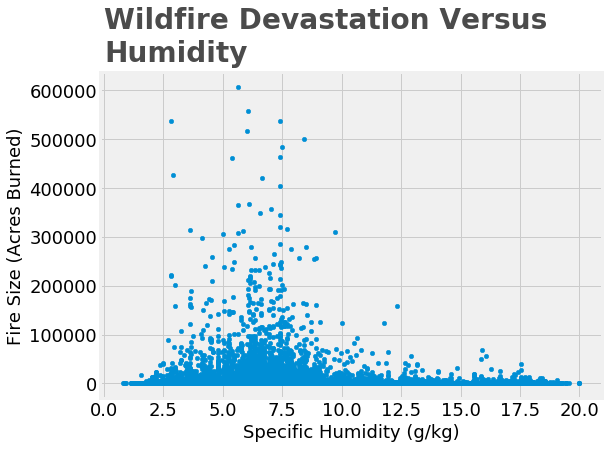

In [41]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

fires_cleaned.plot.scatter(x = 'HUMIDITY', y = 'FIRE_SIZE', ax = ax, fontsize = 18)
ax.set_xlabel('Specific Humidity (g/kg)', fontsize = 18)
ax.set_ylabel('Fire Size (Acres Burned)', fontsize = 18)

ax.text(0, 660000, 'Wildfire Devastation Versus \nHumidity', fontsize = 28, alpha = .7, weight = 'bold');

We see large wildfires for when the specific humidity was between 2.5 to 10 g/kg, with a peak around 6 g/kg. Past 10 g/kg, there is a decrease in the wildfire size. As with temperature, there is no linear relationship between the wildfire size and humidity.

In [42]:
fires_cleaned.sort_values(by = 'FIRE_SIZE', ascending = False).head(20)

,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL,HUMIDITY
21625,61.982700,-157.085700,17.190304,Lightning,AK,1997-06-25,606945.0,1,5.630000
214689,42.391894,-117.893687,25.339746,Lightning,OR,2012-07-08,558198.3,1,6.070000
195087,33.606111,-109.449722,19.759136,Campfire,AZ,2011-05-29,538049.0,0,2.803334
35709,65.266300,-146.885800,14.809540,Lightning,AK,2004-06-13,537627.0,1,7.397084
169102,64.746700,-149.504700,12.932002,Lightning,AK,2009-06-21,517078.0,1,5.996000
15521,42.038889,-123.911667,20.982557,Lightning,OR,2002-07-13,499945.0,1,8.405000
35770,66.302900,-149.884300,15.444478,Lightning,AK,2004-07-06,483280.0,1,7.491110
35743,63.816300,-143.819000,16.562939,Lightning,AK,2004-06-18,463994.0,1,7.397084
214296,41.973300,-118.365000,24.236391,Lightning,OR,2012-08-05,461047.0,1,5.371429
994,35.216667,-100.933333,14.012645,Miscellaneous,TX,2006-03-12,427696.0,1,2.914615


While we haven't done any machine learning yet, we note that the twenty largest wildfires in this dataset have occurred in the temperature range 12 to 25$^\mathrm{o}$C and the specific humidity range 2.8 to 8.4 g/kg.

What we have noticed is that the maximum fire size peaks at specific values of the temperature and humidity. What if we plot the maximum fire size against these two variables?

In [46]:
temperature_humidity_fire = fires_cleaned[['TEMPERATURE', 'HUMIDITY', 'FIRE_SIZE']]

temperature_humidity_fire.head()

,TEMPERATURE,HUMIDITY,FIRE_SIZE
0,17.886902,7.333685,16823.0
1,19.159416,7.333685,7700.0
2,25.693935,9.016666,10.0
3,5.026590,4.124762,50.3
4,0.772786,3.756667,125.0


In [257]:
# Assign an index to fire based on the temperature and humidity. 
# We are clustering these variables into intervals
def defineHeatmapIndex(row):
    # Get the x and y coordinates
    x = row['HUMIDITY']
    y = row['TEMPERATURE']
    
    # For a given y value y0, we have 21 values of humidity
    index = x // .25 + ((y + 30) // 1.25) * 81
    
    return index

In [284]:
# Assign cluster indices to each fire
temperature_humidity_fire['index'] = temperature_humidity_fire.apply(defineHeatmapIndex, axis = 1)
# For each cluster, obtain the maximum fire size
grouped_fire_size = temperature_humidity_fire.groupby(by = 'index')['FIRE_SIZE'].max()

# Define array that will be reshaped into a matrix for our heatmap.
# Initialize with zeros for (T, humidity) intervals with no fires
fire_size_heat_map = np.ones(4617)

for i in range(4617):
    if i in grouped_fire_size.index:
        fire_size_heat_map[i] = grouped_fire_size[i]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


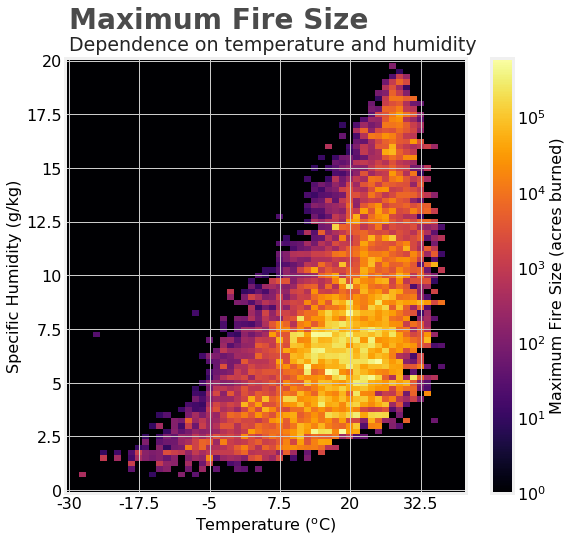

In [298]:
import matplotlib.colors as colors

# Reshape the array into a 2D matrix, which will be what we plot with the heatmap
fire_size_heat_map_matrix = np.reshape(fire_size_heat_map, (81,57), order = 'F')

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

im = ax.imshow(fire_size_heat_map_matrix, origin = 'lower', cmap = 'inferno', aspect = 'auto',
               norm = colors.LogNorm(vmin = 1, 
                                     vmax = grouped_fire_size.max()))
ax.set_xticks(np.arange(0, 57, 10))
ax.set_xticklabels(['-30', '-17.5', '-5', '7.5', '20', '32.5'], fontsize = 16)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize = 16)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize = 16)
ax.grid(which = 'minor')

cbar = fig.colorbar(im)
cbar.set_label('Maximum Fire Size (acres burned)', size = 16)
cbar.ax.tick_params(labelsize = 16)

ax.text(0, 86, 'Maximum Fire Size', fontsize = 28, alpha = .7, weight = 'bold')
ax.text(0, 82, 'Dependence on temperature and humidity', fontsize = 19, alpha = .85);

The largest maximum fire sizes were seen at temperatures just below 20$^\mathrm{o}$C and specific humidities around 7 g/kg. The maximum fire size decreases away from this coordinate point. At high humidities, the largest fires were observed at high temperatures close to 30$^\mathrm{o}$C. At lower temperatures, large fires were observed in dry conditions. No fires were seen for specific regions of the temperature-humidity grid, as conditions like below freezing temperatures with high humidity are not physically possible.

Let us do the same analysis for the *mean* fire sizes.

In [282]:
# For each cluster, obtain the mean fire size
grouped_mean_fire_size = temperature_humidity_fire.groupby(by = 'index')['FIRE_SIZE'].mean()

# Define array that will be reshaped into a matrix for our heatmap.
# Initialize with zeros for (T, humidity) intervals with no fires
mean_fire_size_heat_map = np.ones(4617)

for i in range(4617):
    if i in grouped_mean_fire_size.index:
        mean_fire_size_heat_map[i] = grouped_mean_fire_size[i]

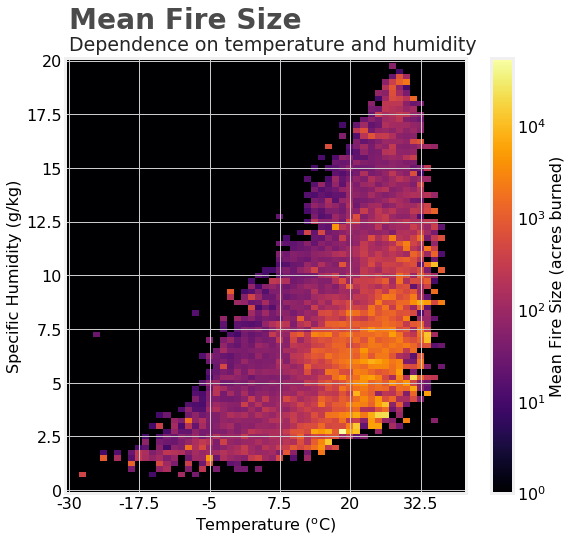

In [301]:
# Reshape the array into a 2D matrix, which will be what we plot with the heatmap
mean_fire_size_heat_map_matrix = np.reshape(mean_fire_size_heat_map, (81,57), order = 'F')

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

im = ax.imshow(mean_fire_size_heat_map_matrix, origin = 'lower', cmap = 'inferno', aspect = 'auto',
               norm = colors.LogNorm(vmin = 1, 
                                     vmax = grouped_mean_fire_size.max()))
ax.set_xticks(np.arange(0, 57, 10))
ax.set_xticklabels(['-30', '-17.5', '-5', '7.5', '20', '32.5'], fontsize = 16)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize = 16)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize = 16)
ax.grid(which = 'minor')

cbar = fig.colorbar(im)
cbar.set_label('Mean Fire Size (acres burned)', size = 16)
cbar.ax.tick_params(labelsize = 16)

ax.text(0, 86, 'Mean Fire Size', fontsize = 28, alpha = .7, weight = 'bold')
ax.text(0, 82, 'Dependence on temperature and humidity', fontsize = 19, alpha = .85);

On average, the largest fires were observed at high temperatures between 20 and 30$^\mathrm{o}$C in dry conditions, where the specific humidity is between 2.5 and 7.5 g/kg. What this means is that we expect to see large fires. The information we don't get from this plot, however, is the spread in values for the fire sizes and the outliers, which can describe fires that burn almost a million acres. That is information that can be observed from *both plots* of the mean and maximum fire sizes.

Let us repeat this visualization exercise, where we only look at wildfires caused by humans.

In [305]:
human_temperature_humidity_fire = fires_cleaned[fires_cleaned['NATURAL'] == 0][['TEMPERATURE', 
                                                                                'HUMIDITY', 'FIRE_SIZE']]

human_temperature_humidity_fire.head()

,TEMPERATURE,HUMIDITY,FIRE_SIZE
0,17.886902,7.333685,16823.0
1,19.159416,7.333685,7700.0
3,5.026590,4.124762,50.3
4,0.772786,3.756667,125.0
5,10.880407,5.727143,25.0


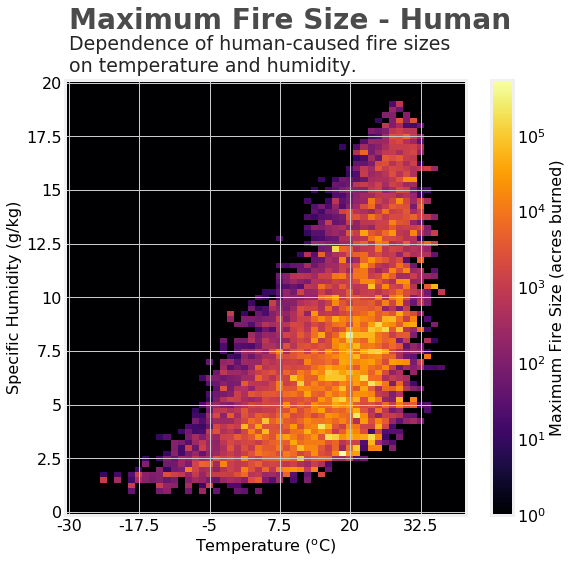

In [312]:
# Assign cluster indices to each fire
human_temperature_humidity_fire['index'] = human_temperature_humidity_fire.apply(defineHeatmapIndex, axis = 1)
# For each cluster, obtain the maximum fire size
human_grouped_fire_size = human_temperature_humidity_fire.groupby(by = 'index')['FIRE_SIZE'].max()

# Define array that will be reshaped into a matrix for our heatmap.
# Initialize with zeros for (T, humidity) intervals with no fires
human_fire_size_heat_map = np.ones(4617)

for i in range(4617):
    if i in human_grouped_fire_size.index:
        human_fire_size_heat_map[i] = human_grouped_fire_size[i]
        
# Reshape the array into a 2D matrix, which will be what we plot with the heatmap
human_fire_size_heat_map_matrix = np.reshape(human_fire_size_heat_map, (81,57), order = 'F')

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

im = ax.imshow(human_fire_size_heat_map_matrix, origin = 'lower', cmap = 'inferno', aspect = 'auto',
               norm = colors.LogNorm(vmin = 1, 
                                     vmax = human_grouped_fire_size.max()))
ax.set_xticks(np.arange(0, 57, 10))
ax.set_xticklabels(['-30', '-17.5', '-5', '7.5', '20', '32.5'], fontsize = 16)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize = 16)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize = 16)
ax.grid(which = 'minor')

cbar = fig.colorbar(im)
cbar.set_label('Maximum Fire Size (acres burned)', size = 16)
cbar.ax.tick_params(labelsize = 16)

ax.text(0, 90, 'Maximum Fire Size - Human', fontsize = 28, alpha = .7, weight = 'bold')
ax.text(0, 82, 'Dependence of human-caused fire sizes\non temperature and humidity.', fontsize = 19, alpha = .85);

This figure is similar to our previous heatmap of maximum fire sizes. Based on where the peak values seem to be, one thing we can say is that most destructive fires caused by humans have occurred at higher temperatures than for the most destructive fires caused by lightning.

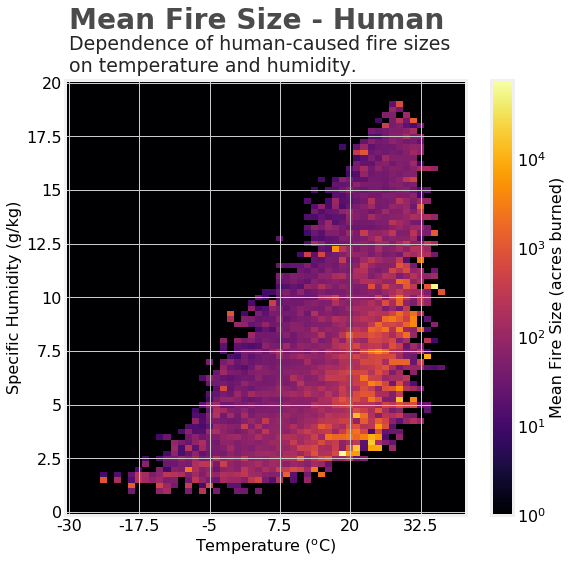

In [316]:
# Assign cluster indices to each fire
human_temperature_humidity_fire['index'] = human_temperature_humidity_fire.apply(defineHeatmapIndex, axis = 1)
# For each cluster, obtain the maximum fire size
human_grouped_mean_fire_size = human_temperature_humidity_fire.groupby(by = 'index')['FIRE_SIZE'].mean()

# Define array that will be reshaped into a matrix for our heatmap.
# Initialize with zeros for (T, humidity) intervals with no fires
human_mean_fire_size_heat_map = np.ones(4617)

for i in range(4617):
    if i in human_grouped_mean_fire_size.index:
        human_mean_fire_size_heat_map[i] = human_grouped_mean_fire_size[i]
        
# Reshape the array into a 2D matrix, which will be what we plot with the heatmap
human_mean_fire_size_heat_map_matrix = np.reshape(human_mean_fire_size_heat_map, (81,57), order = 'F')

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

im = ax.imshow(human_mean_fire_size_heat_map_matrix, origin = 'lower', cmap = 'inferno', aspect = 'auto',
               norm = colors.LogNorm(vmin = 1, 
                                     vmax = human_grouped_mean_fire_size.max()))
ax.set_xticks(np.arange(0, 57, 10))
ax.set_xticklabels(['-30', '-17.5', '-5', '7.5', '20', '32.5'], fontsize = 16)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize = 16)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize = 16)
ax.grid(which = 'minor')

cbar = fig.colorbar(im)
cbar.set_label('Mean Fire Size (acres burned)', size = 16)
cbar.ax.tick_params(labelsize = 16)

ax.text(0, 90, 'Mean Fire Size - Human', fontsize = 28, alpha = .7, weight = 'bold')
ax.text(0, 82, 'Dependence of human-caused fire sizes\non temperature and humidity.', fontsize = 19, alpha = .85);

The lower intensity in this plot shows that fires caused by humans, on average, burn less land than fires caused by natural causes. On average, the most destructive human caused wildfires occur at high temperatures of at least 20$^\mathrm{o}$C under dry conditions, where the specific humidity is around 5 g/kg.

# Machine Learning
We may wish to train a machine learning model that predicts the size of wildfires given, say, values for the temperature and humidity. This may be a difficult task, considering how a majority of the fires have burned roughly 100 to 1000 acres, whereas the most devastating wildfires that have burned an order of magnitude greater number of acres are in the minority. We would want such a model to predict these minority values, which may be treated as outliers in other cases.

We are going to simplify this problem by predicting whether or not a fire is going to be categorized as Class G or not. In other words, the model will predict whether or not a fire will burn 5000 or more acres. Class G alone covers a wide variety of wildfires, from burning 5,000 acres to roughly 600,000 acres. The fact that a given location in the United States may be in danger of any Class G wildfire warrants attention to reducing the impact of lightning or preventing humans from causing wildfires altogether.

We will define a new target variable based on the FIRE_SIZE column.

In [118]:
def isClassG(row):
    if row['FIRE_SIZE'] >= 5000:
        return 1
    else:
        return 0
    
fires_cleaned['CLASS_G'] = fires_cleaned.apply(isClassG, axis = 1)

fires_cleaned.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE,FIRE_SIZE,NATURAL,HUMIDITY,CLASS_G
0,38.523333,-120.211667,17.886902,Equipment Use,CA,2004-10-06,16823.0,0,7.333685,1
1,38.780000,-120.260000,19.159416,Equipment Use,CA,2004-10-13,7700.0,0,7.333685,1
2,33.315833,-105.512222,25.693935,Lightning,NM,2004-07-20,10.0,1,9.016666,0
3,35.000278,-83.351111,5.026590,Arson,NC,2005-01-27,50.3,0,4.124762,0
4,36.001667,-81.590000,0.772786,Debris Burning,NC,2005-02-12,125.0,0,3.756667,0


Let us examine how many of the fires in our dataset are fire size Class G, and how many are not.

In [119]:
fires_cleaned['CLASS_G'].value_counts()

0    243576
1      3520
Name: CLASS_G, dtype: int64

1.42% of the wildfires in our dataset are categorized as Class G. This dataset is incredibly imbalanced. We need to keep this in mind for our predictions.

We are going to consider feature selection once more. Our target variable is going to be "CLASS_G". For our independent variables, we will select:
- TEMPERATURE
- HUMIDITY
- NATURAL

"NATURAL" already covers for the categorical variable "STAT_CAUSE_DESCR". GPS coordinates will likely not have a numerical relationship with our target. We are not downplaying the "LATITUDE" and "LONGITUDE" columns, as these variables were how we were able to include "TEMPERATURE" and "HUMIDITY" in our dataset. We have already said we were going to exclude "STATE" and "DISCOVERY_DATE" from machine learning.

For validation, we are going to try splitting the data into training, test, and validation sets. We want to make sure that when we split the data, the ratio of "CLASS_G" classes is consistent between the sets.

We will split our dataset by the 80/20 ratio, so that 20% of the data is in the test set. The remaining dataset will be further split by the 80/20 ratio, giving us our training and validation sets, respectively.

In [127]:
from sklearn.model_selection import StratifiedShuffleSplit

features = fires_cleaned[['TEMPERATURE', 'HUMIDITY', 'NATURAL']]
target = fires_cleaned['CLASS_G']

# Stratified splitting will preserve the ratio of classes. Split into 80/20.
sss = StratifiedShuffleSplit(random_state = 42, test_size = .2)

# Get numpy arrays of the features and target DataFrames
X = features.values
y = target.values

# Split test from what will be both training and validation
for train_index, test_index in sss.split(X, y):
    X_train_valid, X_test = X[train_index], X[test_index]
    y_train_valid, y_test = y[train_index], y[test_index]
    
# Split validation from training
for train_index, valid_index in sss.split(X_train_valid, y_train_valid):
    X_train, X_valid = X_train_valid[train_index], X_train_valid[valid_index]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]

print('Training:')
print(pd.Series(y_train).value_counts() / len(y_train))
print('Test:')
print(pd.Series(y_test).value_counts() / len(y_test))
print('Validation:')
print(pd.Series(y_valid).value_counts() / len(y_valid))

Training:
0    0.985753
1    0.014247
dtype: float64
Test:
0    0.985755
1    0.014245
dtype: float64
Validation:
0    0.98576
1    0.01424
dtype: float64


We have prepared three datasets with similar ratios for the two classes: "Class G" and "Not Class G". Let us try a simple machine learning model, like logistic regression. 

We need an error metric to address the class imbalance: A majority of the data points are "negative" ("Not Class G"). We want to maximize the number of true positives in our prediction, as this will allow us to predict conditions when devastating fires may occur. 

We want to minimize the number of false negatives, where the model predicts Class G wildfires will never happen for conditions where Class G wildfires *do* happen. The inability to predict where and when a wildfire can be incredily destructive is severe, as we would be looking at widespread property damage and even loss of life. With this in mind, we wish to maximize the recall *R*:

\begin{equation}
R = \frac{tp}{tp + fn}
\end{equation}

However, we don't want to maximize *just* the recall. If we do so, we could end up with a model that simply says all fires are Class G wildfires, and they will happen *all the time*, which isn't true and is misleading, and results in a machine learning model that has little use for real-life applications. We need to be mindful of the number of false positives, and the precision *P*:

\begin{equation}
P = \frac{tp}{tp + fp}
\end{equation}

We will use the average precision (AP) to score our model:

\begin{equation}
\mathrm{AP} = \sum_n (R_n - R_{n-1})P_n
\end{equation}

We wish to maximize the average precision. For various probabilitiy thresholds, we want to maximize both the precision and recall as best as we can, although if we need to, we will want to prioritize recall over precision.

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

# Instantiate the logistic regression model
# Set class_weight to "balanced". Model will penalize the misclassification of the minority class.
lr = LogisticRegression(class_weight = 'balanced')

# Fit to the training data, and predict training labels
lr.fit(X_train, y_train)
prediction_train_balanced = lr.predict(X_train)

# Calculate the average precision score
print('Training AP score:', average_precision_score(y_train, prediction_train_balanced))

# Predict the test labels
prediction_test_balanced = lr.predict(X_test)

# Calculate the average precision score
print('Test AP score:', average_precision_score(y_test, prediction_test_balanced))

Training AP score: 0.04070826277609589
Test AP score: 0.041551072728279334


Ideally, we would like an AP score as close to one as possible. However, we have an AP score close to 0. The AP score is impacted by both the precision and recall. We previously said we are okay with having false positives, which will decrease the precision. However, we wish to minimize the number of false negatives and maximize our recall. Let us check these metrics.

In [317]:
from sklearn.metrics import precision_score, recall_score

# Predict the validation labels
prediction_valid_balanced = lr.predict(X_valid)

# Precision and recall for the three datasets from the LR model
print('Training precision:', precision_score(y_train, prediction_train_balanced))
print('Test precision:', precision_score(y_test, prediction_test_balanced))
print('Validation precision:', precision_score(y_valid, prediction_valid_balanced), '\n')

print('Training recall:', recall_score(y_train, prediction_train_balanced))
print('Test recall:', recall_score(y_test, prediction_test_balanced))
print('Validation recall:', recall_score(y_valid, prediction_valid_balanced))

Training precision: 0.04742300688781569
Test precision: 0.04814877717391304
Validation precision: 0.04761403139155167 

Training recall: 0.7976031957390146
Test recall: 0.8053977272727273
Validation recall: 0.8028419182948491


We see why our AP score is close to zero: Low precision from allowing our model to predict false positives. However, we see that our recall is close to one. We see that the predictions made for the test and validation datasets have similar error metrics.

Let us try out a different machine learning model, gradient boosted decision trees implemented with LightGBM. We are manually setting the parameter scale_pos_weight, which is LightGBM's penalty parameter for the misclassification of the minority class, and is equal to the ratio of the number of negative samples ("not Class G") and the number of positive samples ("Class G"). 

We will try to find our optimal set of parameters through grid search cross validation. This set of parameters should ideally result in the best AP score.

In [210]:
import lightgbm as lgb

if __name__ == '__main__':
    # Set parameter grid
    parameters = {
        'learning_rate': [0.02,0.05],
        'num_leaves': [8, 16, 32, 64],
        'min_data_in_leaf': [50, 100, 200, 500],
        'n_estimators': [500, 1000, 2000],
        'max_depth': [4, 8, 12]
    }
    
    # Instantiate the LightGBM classifier model. Set penalty and objective (binary classification)
    gbm = lgb.LGBMClassifier(objective = 'binary', verbose = 0, scale_pos_weight = 69.19085663559699)
    
    # Instantiate the grid for grid search. Score models based on AP score.
    # Cross-validation is done with three stratified folds (folds have same ratios of classes)
    gbm_grid = GridSearchCV(gbm, param_grid = parameters, scoring = 'average_precision', 
                            cv = StratifiedKFold(n_splits = 3), refit = True, n_jobs = 1)
    
    # Fit the models in the grid to the training data
    gbm_grid.fit(X_train, y_train)

    # Return the parameters for the model with the best AP score
    print('Best parameters from GridSearchCV: ')
    print(gbm_grid.best_params_)

    # Return the model with the best AP score
    gbm = gbm_grid.best_estimator_
    
    # Predict the training labels with this best estimator
    prediction_train = np.round(gbm.predict(X_train))

    print('Training AP score:', average_precision_score(y_train, prediction_train))

    # Predict the test labels with this best estimator
    prediction_test = np.round(gbm.predict(X_test))

    print('Test AP score:', average_precision_score(y_test, prediction_test))

Best parameters from GridSearchCV: 
{'learning_rate': 0.02, 'max_depth': 12, 'min_data_in_leaf': 50, 'n_estimators': 500, 'num_leaves': 64}
Training AP score: 0.07010956944858483
Test AP score: 0.048596105366489645


We have improved our AP scores in comparison to what we had achieved from logistic regression, especially with the training set. Let us examine the predictions on the training and test sets.

In [211]:
print('Training:')
print(pd.Series(prediction_train).value_counts() / len(prediction_train))
print('Test:')
print(pd.Series(prediction_test).value_counts() / len(prediction_test))

Training:
0    0.816492
1    0.183508
dtype: float64
Test:
0    0.818495
1    0.181505
dtype: float64


If we compare these fractions to the class fractions in our training and test datasets, we see that there are a considerable number of false positives in our prediction. This results in a decreased precision, impacting the average precision score. 

In [212]:
print('Training precision:', precision_score(y_train, prediction_train))
print('Test precision:', precision_score(y_test, prediction_test))

Training precision: 0.0733631977946244
Test precision: 0.05953177257525084


What we notice is that these precision scores are actually better than what we had obtained from logistic regression.

Let us check the recall.

In [213]:
print('Training recall:', recall_score(y_train, prediction_train))
print('Test recall:', recall_score(y_test, prediction_test))

Training recall: 0.9449622725255216
Test recall: 0.7585227272727273


Our recall score for the prediction on the training set is better than for logistic regression, but the recall score for the prediction on the test set is worse than for logistic regression. We will need to further tune the hyperparameters of our LightGBM model to deal this overfitting. 

In [255]:
gbm_tuned = lgb.LGBMClassifier(objective = 'binary', verbose = 0, scale_pos_weight = 69.19085663559699,
                               learning_rate = 0.02, max_depth = 8, min_data_in_leaf = 50, n_estimators = 1000, 
                               num_leaves = 7, max_bin = 500)

gbm_tuned.fit(X_train, y_train)

prediction_train = np.round(gbm_tuned.predict(X_train))

prediction_test = np.round(gbm_tuned.predict(X_test))

print('Training AP score:', average_precision_score(y_train, prediction_train))
print('Test AP score:', average_precision_score(y_test, prediction_test))

print('Training precision:', precision_score(y_train, prediction_train))
print('Test precision:', precision_score(y_test, prediction_test))

print('Training recall:', recall_score(y_train, prediction_train))
print('Test recall:', recall_score(y_test, prediction_test))

Training AP score: 0.04891368594202872
Test AP score: 0.04832032510589448
Training precision: 0.0561034275405893
Test precision: 0.055748456790123455
Training recall: 0.8282290279627164
Test recall: 0.8210227272727273


What we have done with the LightGBM model we obtained from grid search cross validation was we:
- Trimmed the individual trees by reducing the maximum depth, preventing deep trees from overfitting to the training data
- Reduced the number of leaves, also reducing overfitting
- Increased the number of estimators (iterations/trees) to 1000 for higher accuracy
- Increased the maximum number of bins that feature values are bucketed in

This has given us predictions where all error metrics (AP score, precision, recall) are better than those from logistic regression for both the training and test datasets. We have lower error metrics for the training dataset than for our previous LightGBM model, but the metrics are similar between the training and test sets, meaning this model is more likely to be a generalized model.

Let us examine the predictions on the training and test sets.

In [318]:
print('Training:')
print(pd.Series(prediction_train).value_counts() / len(prediction_train))
print('Test:')
print(pd.Series(prediction_test).value_counts() / len(prediction_test))

Training:
0    0.78968
1    0.21032
dtype: float64
Test:
0    0.790206
1    0.209794
dtype: float64


In comparison to our previous LightGBM model, there are many more false positives, which explains our lower precision. However, there are fewer false negatives, which explains our higher recall.

Let us evaluate these metrics on the validation set to make sure this model is generalized.

In [256]:
prediction_valid = np.round(gbm_tuned.predict(X_valid))

print('Validation AP score:', average_precision_score(y_valid, prediction_valid))
print('Validation precision:', precision_score(y_valid, prediction_valid))
print('Validation recall:', recall_score(y_valid, prediction_valid))

Validation AP score: 0.04706571456617585
Validation precision: 0.05476819601249099
Validation recall: 0.8099467140319716


The error metrics for the predictions on the validation dataset are not as great as those for the training and test datasets, but the validation error metrics are still better for this model than for logistic regression. The validation error metrics are also still close to those metrics for the training and test datasets, meaning this model is generalized.

# Interpretation of Results

What can we do with these results and this predictive machine learning model? We can use our predictions to see the values of temperature and humidity at which Class G wildfire are likely to occur. For this case, let us visualize the temperatures and humidities where *human-caused* Class G wildfires are likely to occur. The resulting figure is a heatmap of a matrix of zeros and ones, where one pertains to "Class G wildfire is likely".

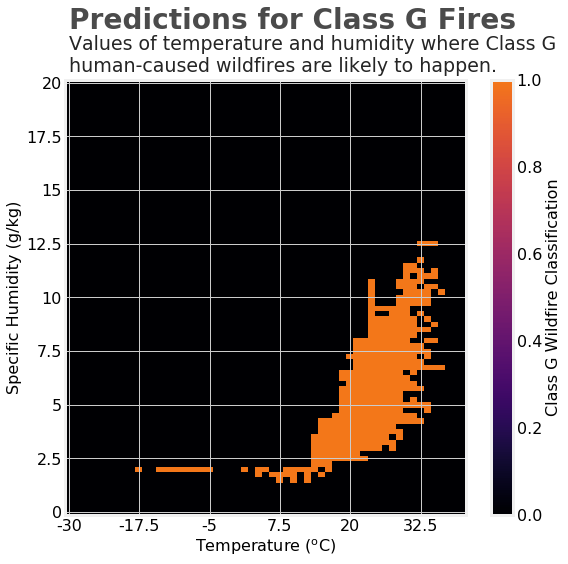

In [349]:
# Input: Numpy arrays X (features) and y (prediction (Class G or no))
# Output: A DataFrame with columns for temperature, humidity, and fire size/predicted classification (Class G)
def reconstructDF(X, y):
    # Combine X and y into one matrix (add y as a column)
    matrix = np.column_stack((X[:, :-1], y))
    
    # Make a DataFrame only out of rows where the third column is zero
    # The third column pertains to the NATURAL variable. Zero means human-caused.
    df = pd.DataFrame(matrix[X[:, 2] == 0], columns = ['TEMPERATURE', 'HUMIDITY', 'FIRE_SIZE'])
    
    return df

# Get DataFrames out of the feature and prediction numpy arrays for the three datasets. Combine the DFs.
training_df = reconstructDF(X_train, prediction_train)
test_df = reconstructDF(X_test, prediction_test)
valid_df = reconstructDF(X_valid, prediction_valid)

merged_df = pd.concat([training_df, test_df, valid_df])

# Assign cluster indices to each fire
merged_df['index'] = merged_df.apply(defineHeatmapIndex, axis = 1)
# For each cluster, obtain the maximum fire size (1 if it is present at that cluster, 0 otherwise)
predicted_grouped_fire_size = merged_df.groupby(by = 'index')['FIRE_SIZE'].max()

# Define array that will be reshaped into a matrix for our heatmap.
# Initialize with zeros for (T, humidity) intervals with no fires
predicted_fire_size_heat_map = np.zeros(4617)

for i in range(4617):
    if i in predicted_grouped_fire_size.index:
        predicted_fire_size_heat_map[i] = predicted_grouped_fire_size[i]
        
# Reshape the array into a 2D matrix, which will be what we plot with the heatmap
predicted_fire_size_heat_map_matrix = np.reshape(predicted_fire_size_heat_map, (81,57), order = 'F')

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

# Truncate the colormap so that the maximum intensity is orange
inferno_cmap = plt.get_cmap('inferno')
new_cmap = colors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n='inferno', a=0, b=1),
    inferno_cmap(np.linspace(0, 0.7, 1000)))

im = ax.imshow(predicted_fire_size_heat_map_matrix, origin = 'lower', cmap = new_cmap, aspect = 'auto')
ax.set_xticks(np.arange(0, 57, 10))
ax.set_xticklabels(['-30', '-17.5', '-5', '7.5', '20', '32.5'], fontsize = 16)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_yticklabels(['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize = 16)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize = 16)
ax.grid(which = 'minor')

cbar = fig.colorbar(im)
cbar.set_label('Class G Wildfire Classification', size = 16)
cbar.ax.tick_params(labelsize = 16)

ax.text(0, 90, 'Predictions for Class G Fires', fontsize = 28, alpha = .7, weight = 'bold')
ax.text(0, 82, 'Values of temperature and humidity where Class G\nhuman-caused wildfires are likely to happen.', 
        fontsize = 19, alpha = .85);

We see that the shape of the feature corresponding to temperatures and humidities where human-caused Class G wildfires are likely is shaped like the feature in the maximum fire size heatmaps from before. We noted that the largest human-caused wildfires occurred at temperatures of at least 20$^\mathrm{o}$C and at low humidities around 5 g/kg. The above result reflects that. 

The above predictions imply that Class G wildfires are not likely to occur when the specific humidity is above 12.5 g/kg. This would describe conditions where the moisture (and possible rain) would impede the spread of fires. What is odd is that Class G wildfires were predicted for below the freezing point only at very low values of the specific humidity. Despite the cold, our predictions imply that wildfires can dangerously spread in extremely dry conditions. 

What are some insights from this figure? The largest wildfires, and the most devastating wildfires, are most likely in dry conditions, at high temperatures, or both. 

How can this machine learning model be used to predict whether or not wildfires may burn more than 5000 acres in a given location at a given time? The inputs, after all, are temperature, humidity, and whether or not we're predicting natural wildfires or human-caused wildfires. 

That is where forecasting comes into play: Temperatures and humidities must be accurately predicted all over the United States (I'm saying the United States as this database is based off of wildfires in the US). 

And this doesn't mean there are conditions where wildfires will never occur. For instance, just because our machine learning model gave us a zero at the temperature 7.5$^\mathrm{o}$C and specific humidity of 7.5 g/kg doesn't mean fires will never start. Fires can always start. Burning debris can always cause fires. An arson can start a fire anywhere. Campfires and fireworks can start fires anywhere at anytime. This model predicts whether or not a hypothetical fire will grow to a disasterous extent.

And improvements can always be made to our machine learning model. We can, for instance, try to add more features that describe, for example, the population density at a given location, which may affect how often human-caused fires occur. We can also try to add a variable that describes wind conditions at a given time and location, as winds help spread fires.